# DSCI 100 Final report: Can played hours, participant age, and experience predict if a participant is subscribed to a gaming related newsletter?

## Amisha, Rocco, Sophie, Uday

In [40]:
#run this code to read players.csv data 
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
set.seed(2025) #reproducible analysis

players_data <- read_csv("https://raw.githubusercontent.com/roccopbug/dsci_100_group_7_004/refs/heads/main/data/players.csv") 

head(players_data)

#to see how many observations we have without printing the whole dataset
nrow(players_data)

#to see what are the different options of experience, group by, then summarize
experience_counts <- group_by(players_data, experience)|>
    summarize(count = n())

#experience_counts


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


[1] 196

### Introduction:
The Pacific Laboratory for Artificial Intelligence (PLAI) at UBC is collecting data from a Minecraft server to train and develop an advanced AI model. PLAI collected data based on participants playing habits on the server. We will be analyzing the players dataset, using k-nn classification to see if participant age and played hours is able to predict whether or not the participant is subscribed to a gaming related newsletter. Specifically, we're interested to see whether or not our k-nn model will be able to predict the correct category 80% of the time or more with the optimal K.

- Participants of all ages and skill level were included.
- Data was collected on an excel spreadsheet.
- There are 196 observations, meaning we have 196 players' data in players_data
- 7 variables (experience, subscribe, hashedEmail, played_hours, name, gender, age) 
#### Data Description: players.csv 

| Variable      | Type      | Meaning                                      |
|----------------|-----------|----------------------------------------------|
| experience     | factor    | Playing experience of player in MineCraft. Either  Amateur, Beginner, Regular, Pro, or Veteran
| subscribe      | logical   | States if player is subscribed to a game related newsletter (true or false) |
| hashedEmail    | character | Email used by player in MineCraft                               |
| played_hours   | double    | Total hours played by player                        |
| name           | character | Name of user                                 |
| gender         | factor    | Gender of user                               |
| age            | integer   | Age of user (years)                          |





**Issues in Dataset**
- Some variables are not relevant in the dataset in relation to our question, such as hashEmail. This dataset  will need to be tidied before using. 
- Some players in the dataset chose to not specify their gender. This can cause issues if gender is used as a variable in answering a question, since plots or averages can be inaccurate. 
- There may be outliers in the dataset which will vastly effect how k-nn works. If this becomes an issue, we can either remove extreme outliers, or implement a logarithmic scale to our variable
- Inconsistency in the variable names, such as "Age" being capitalized.
- Order of which data is read in (order of variables).


**Broad Question**
- Can a k-nn model, accurately predict a players' subscription status by using certain variables in players.csv?


**Specific Question**
- Can hours played, and age predict whether a MineCraft player subscribes to the game's newsletter?

**How the Dataset Will Help Answer This Question**
- The dataset shows whether each individual is subscribed to the newsletter
- Players hours played reflects on how often a player engages with the game, and can be analyzed the same way as players experience is, with a graph
- Players age may reflect how interested different age groups are in the game, and can be analyzed the same way.
- These are 2 numeric variables which, in a simple manner tell us a lot about our participants

**How to Wrangle the Dataset**
- Select variables specific to the question being answered (subscribe, played_hours, age)
- Tidy the dataset by naming variables in similar matter (all lowercase)
- Split the data into a training and testing dataset  

### Methods and results:
**KNN classification is the most appropriate method to answer this question**
- this is because we are predicting a true/false variable instead of a numeric one
- predictions on non-linear relationships can be made, which is the case for this question

**Selecting and composing a model**
- Use age and hours played as predictors
- Prediction is true/false for subscribe, whether or not the participant is subscribed to a game related newsletter
- After tidying the data, split data in 75/25 format (75 for training, 25 for testing)
- No cross validation (explained in discussion)

In [19]:
#run this code to read tidy data 


players_data_tidy <- players_data |>
    select(subscribe, played_hours, Age)|>
    #select(name, gender, Age, played_hours, experience, subscribe, -hashedEmail, -gender) |>
    rename(age = Age) |>
    mutate(subscribe = as_factor(subscribe))
    #arrange(age) this isn't 100% necessary?

head(players_data_tidy)

sub_pct <- group_by(players_data_tidy, subscribe)|>
                summarize(prop = n()/nrow(players_data_tidy))
sub_pct #very skewed, way more TRUE

subscribe,played_hours,age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


subscribe,prop
<fct>,<dbl>
FALSE,0.2653061
TRUE,0.7346939


Now, compute summary statistics to get a sense of the center/mean of our data

In [20]:
#Compute mean value for each quantitative variable and report mean values in table format 
summary_mean <- players_data_tidy |>
    summarize(mean_age = mean(age, na.rm = TRUE),
              mean_played_hours = mean(played_hours, na.rm = TRUE))

summary_table <- summary_mean |>
    pivot_longer(cols = everything(), 
                 names_to = "variable", 
                 values_to = "mean")

players_means <- summarize(players_data_tidy, #this is how i did it, i dont think summary table is tidy
                                               #since a collumn is just a label/key not a variable
                            mean_age = mean(age, na.rm = TRUE),
                            mean_played_hours = mean(played_hours, na.rm = TRUE))|>
                                mutate(mean_age = round(mean_age, 2),
                                       mean_played_hours = round(mean_played_hours, 2))

summary_table
players_means

variable,mean
<chr>,<dbl>
mean_age,21.139175
mean_played_hours,5.845918


mean_age,mean_played_hours
<dbl>,<dbl>
21.14,5.85


Next, make a exploratory vizualization to see if we can see some kind of relationship between age and played_hours

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


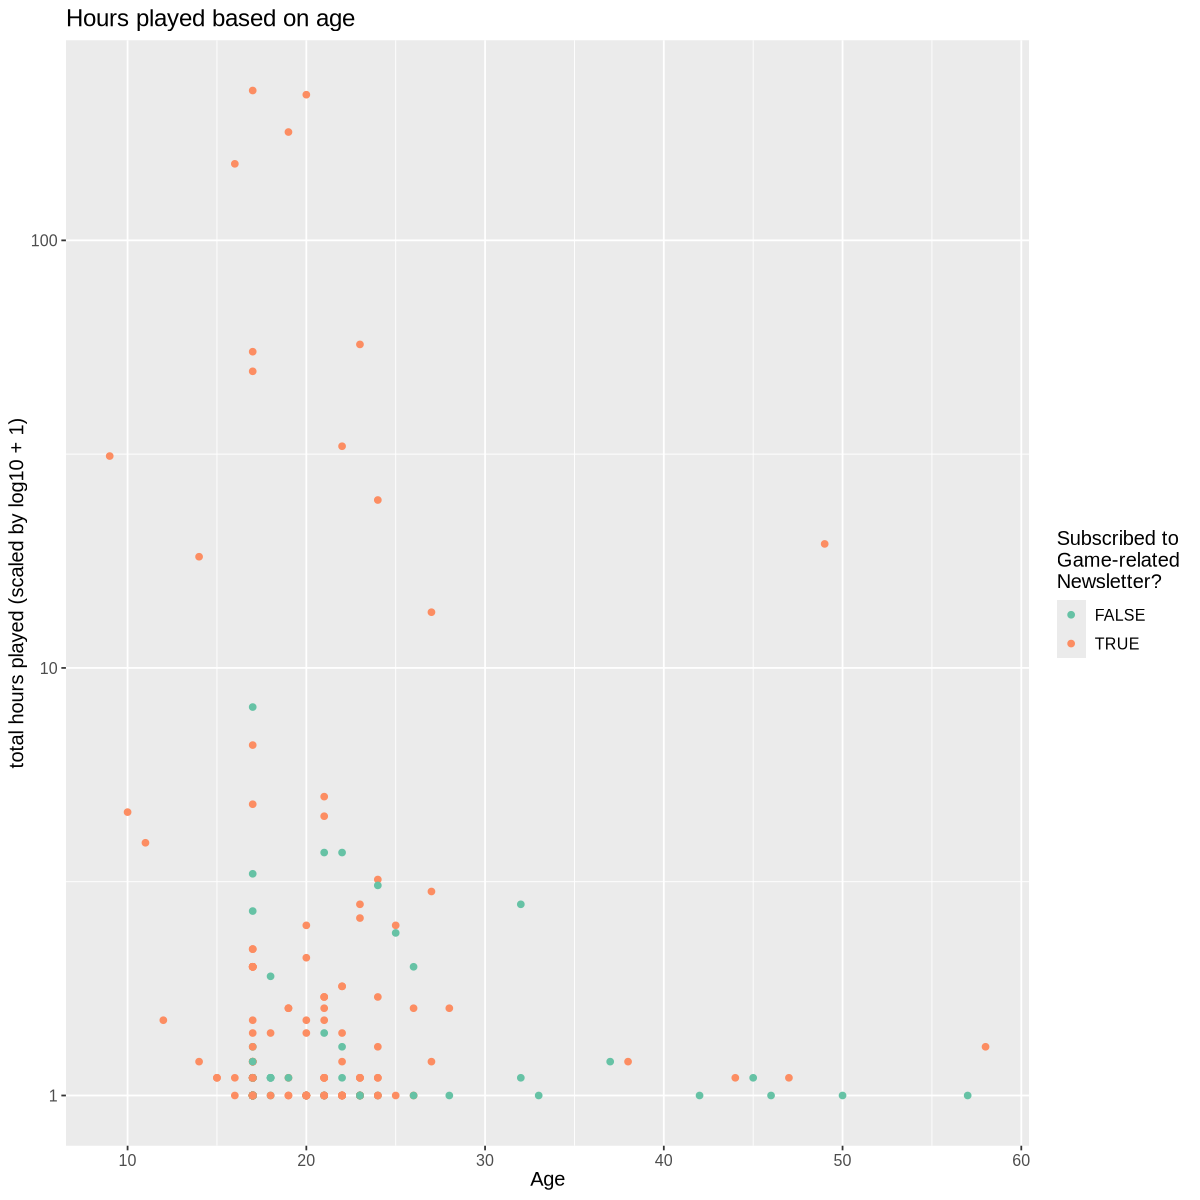

In [65]:
age_hours_plot <- ggplot(players_data_tidy, aes(x = age, y = played_hours + 1, colour = subscribe)) + #avoid log(0)
                    geom_point()+
                    scale_y_log10()+
                    labs(x = "Age", y = "total hours played (scaled by log10 + 1)", colour = "Subscribed to\nGame-related\nNewsletter?")+
                    ggtitle("Hours played based on age") +
                    theme(text = element_text(size = 12)) +
                    scale_color_brewer(palette = "Set2")
age_hours_plot

The age hours plot can be our first step of thinking about this data and if there's some kind of relationship. Our original thought was that as age went up, hours would go down due to less time/priorities. In the graph, we don't really see that, the hours are pretty variable in the 15-25 range. It would've been interesting if we had more data from older people to better see some kind of relationship. We scaled hours_played using log10 since there were some outliers with hundreds of hours that were really stretching out the plot, and not letting us get a good look at the rest of the points. We also added the + 1 to all hours played, since without it, our y axis would exclude data with 0 hours (since log(0) is an error). Along with that, log(1) is equal to 0 so I chose 1 as the scaling to make sure we didnt get any negative y values here. Later, when doing the classification we'll scale the age and hours in terms so it won't matter but for this exploratory vizualization we need it. From the coloured points, we can see with higher ages, or less hours we generally see more red points compared to younger, more frequent players.

### Data analysis
#### Training/test split:
Split our data so 75% is training and the other 25% of data is saved for testing


In [23]:
players_split <- initial_split(players_data_tidy, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)
#head(players_train)
#head(players_test)

#### Recipe:
Setup a recipe, and scale the data so neither played_hours, nor age has more power when predicting

In [24]:
players_recipe <- recipe(subscribe ~ age + played_hours , data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



Now to get a sense of a model predicting subscription status based on age and played_hours, manually testing for k, we see k = 3 will yield us our most accurate predictor, whilst not having a k to high and underfitting.

In [59]:
#knn with a set k
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3)|>
        set_engine("kknn") |>
        set_mode("classification")

#fit on the training data
players_fit <- workflow()|>
        add_recipe(players_recipe)|>
        add_model(players_spec)|>
        fit(data = players_train)

players_test_predictions <- predict(players_fit , players_test) |>
       bind_cols(players_test)

#players_test_predictions

#see how accurate our model with 5 neighbors is
players_prediction_accuracy <- players_test_predictions |>
         metrics(truth = subscribe, estimate = .pred_class)|>
            filter(.metric == "accuracy")|>
            select(.metric, .estimate)

players_prediction_accuracy

players_mat <- players_test_predictions |> 
       conf_mat(truth = subscribe, estimate = .pred_class)

players_mat

.metric,.estimate
<chr>,<dbl>
accuracy,0.6734694


          Truth
Prediction FALSE TRUE
     FALSE     8   11
     TRUE      5   25

With k = 3, we see our model is correct in it's prediction 67% of the time. By looking at the confusion matrix, we see that the model is pretty good at predicting TRUE cases correctly. However, the false cases are not quite as accurate. This is most likely due to the fact that there is a majority of TRUE data points, so it is harder for the model to accurately label something as FALSE.

Now, let's vizualize our how the model predicted subscription status, versus the real value of subscription status in our data

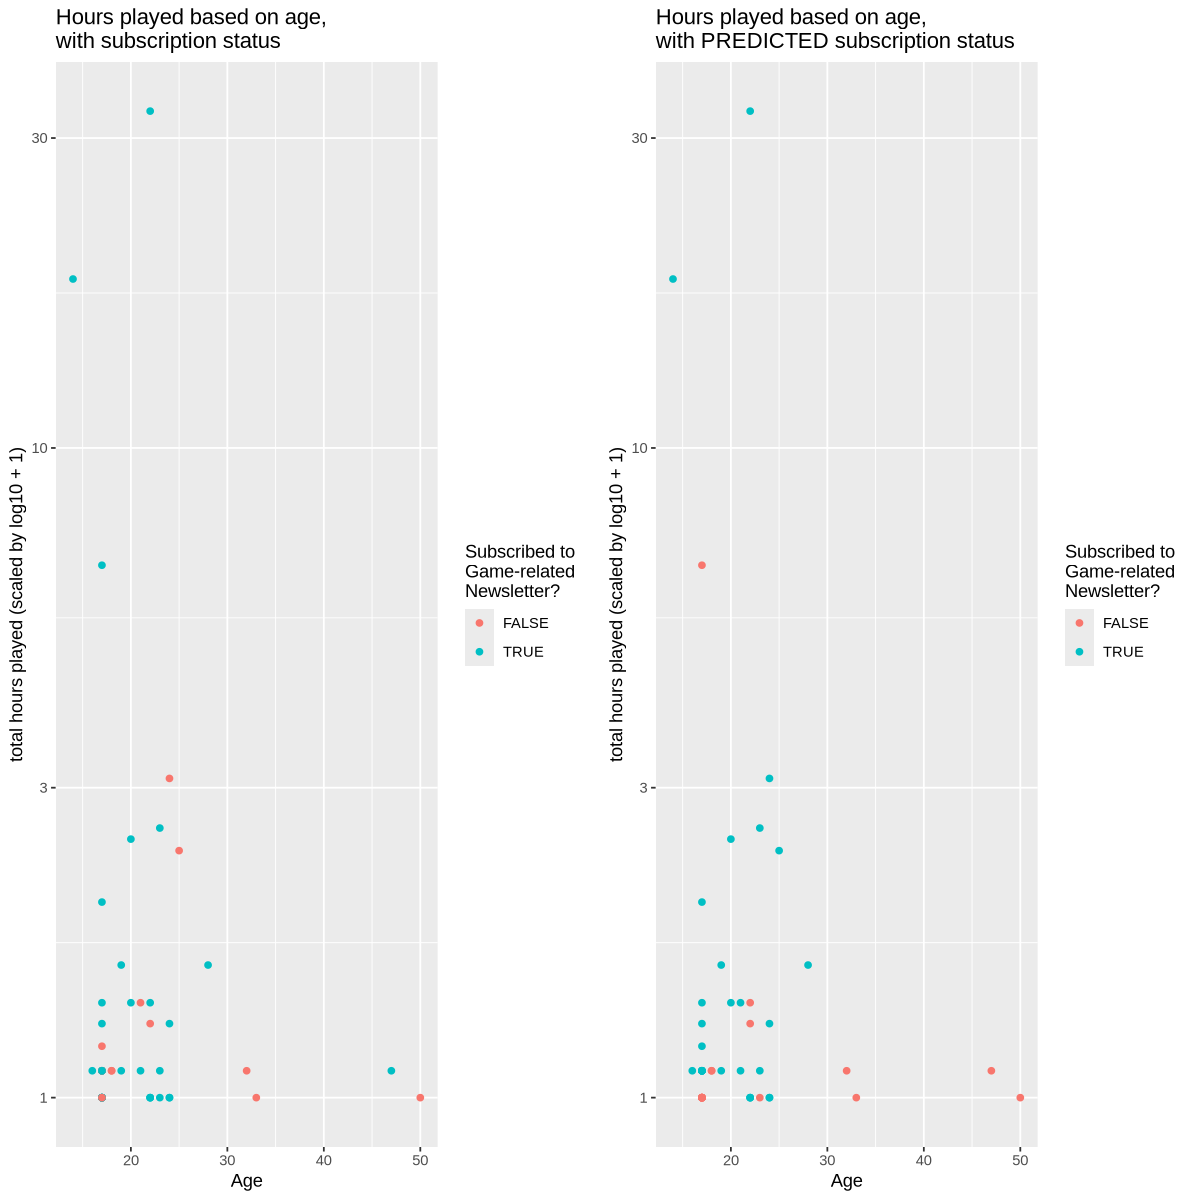

In [60]:
test_real_plot <- ggplot(players_test_predictions, aes(x = age, y = played_hours + 1, colour = subscribe)) +
                        geom_point() +
                        scale_y_log10()+
                    labs(x = "Age", y = "total hours played (scaled by log10 + 1)",
                    colour = "Subscribed to\nGame-related\nNewsletter?")+
                    ggtitle("Hours played based on age,\nwith subscription status")
#test_real_plot

test_pred_plot <- ggplot(players_test_predictions, aes(x = age, y = played_hours + 1,
                                                           colour = .pred_class)) +
                        geom_point() +
                        scale_y_log10()+
                        labs(x = "Age", y = "total hours played (scaled by log10 + 1)",
                        colour = "Subscribed to\nGame-related\nNewsletter?")+
                        ggtitle("Hours played based on age,\nwith PREDICTED subscription status")
plot_grid(test_real_plot, test_pred_plot, ncol = 2)

Here is a vizualization of the differences in the predictions vs true values. A very telling part of the data comes at around the age 25 and 3 hour mark. We see there is 2 FALSE points with 2 TRUE points. When classifying the FALSE points, there simply isn't enough other FALSE points nearby to correctly predict that they are FALSE points.

### Discussion
Before talking about our results, we must discuss the limitations of our project/model. Due to the relatively small dataset and class imbalance in the subscribe variable, stratified v-fold cross-validation failed since some folds did not contain enough observations from the FALSE class. This led to a "orig_rows" error, leading to us not being able to see accuracy/the optimal k. It's also possible that played_hours and age aren't great predictors for subscribe, which could explain why our accuracy was quite low

Because of this limiation, we evaluated the model performance on a single train/test split with a handpicked k instead. We acknowledge that results should be interpreted cautiously due to this limitation.

We found that, our model was accurate 67% of the time, when predicting subscription status in the players dataset. This is not great, and not very close to our "goal" of a model that is 80% accurate. We expected a better model, but this could have been a unrealistic expectation, due to how skewed the data is to have more TRUE subscription status participants. Our findings show that, if we want a model that is fairly accurate, we need a bigger dataset to yield a better prediction. The participants itself could be tuned as well, since this is a study that uses minecraft, it is very likely that most participants are gamers and know of minecraft. Thus it makes sense that most participants are subscribed to a game-related newsletter. Future research with a more balanced participant pool could help us develop a more powerful model. In the future, a better model could be used as a sort of consumer "sorter" that could be used by a newsletter. Meaning that, the newsletter could use data like age and played_hours to predict who isn't subscribed to a game-related newsletter. Knowing this, could help the newsletter better direct advertising efforts to people that are more likely to subscribe to them. Overall, for this future idea to be realized, we need a better model that can predict subscription status in a more accurate way.

**Github Link**
https://github.com/roccopbug/dsci_100_group_7_004